![Abolish the Police](images/police-cars-revolving-light.png)

# Terry Stop Analysis Project

**Author:** Sierra Stanton
***

## Overview

This project analyses records of police reported stops as documented by the Seatlle Police Department for the Supreme Court case Terry v. Ohio.

In Terry v. Ohio (Links to an external site.), a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers.

## Problem

Data.gov has released a public dataset representing Terry Stops in Seattle, Washington, and the various factors that might influence both the original stop and the outcome of said stop.

We'll build a classifier to help predict whether an arrest was made after a Terry Stop, given various factors like the presence of weapons, the subject's race and gender, and more.

This informative data can not only help us predict whether an arrest would be made based on certain perceived factors, but we'll be able to better evaluate the practice altogether and better understand how perception plays a role in police practices.

## Data Understanding

Data will be used from the following source:
* __[Data.gov](https://catalog.data.gov/dataset/terry-stops)__

Data.gov's Terry Stops (`Terry_Stops.csv`): this dataset represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop and contains perceived demographics of the subject, as reported by the officer making the stop and officer demographics as reported to the Seattle Police Department.

We'll import packages from a variety of sources to aid in our exploration and modeling of our data.

In [1]:
# import necessary packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

## Import: Terry Stop Data

Let's ensure we import the necessary data set and begin an exploration of our records.

In [2]:
# import Terry_Stops.csv from our data folder

df_ts = pd.read_csv('data/Terry_Stops.csv')
df_ts.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47297 entries, 0 to 47296
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47297 non-null  object
 1   Subject ID                47297 non-null  int64 
 2   GO / SC Num               47297 non-null  int64 
 3   Terry Stop ID             47297 non-null  int64 
 4   Stop Resolution           47297 non-null  object
 5   Weapon Type               47297 non-null  object
 6   Officer ID                47297 non-null  object
 7   Officer YOB               47297 non-null  int64 
 8   Officer Gender            47297 non-null  object
 9   Officer Race              47297 non-null  object
 10  Subject Perceived Race    47297 non-null  object
 11  Subject Perceived Gender  47297 non-null  object
 12  Reported Date             47297 non-null  object
 13  Reported Time             47297 non-null  object
 14  Initial Call Type     

## Data Preparation

From our initial exploration above, we can see that there are many relevant factors to analyze why a terry stop was made, the nature of said stop, and the outcome. Please consult the __[data dictionary](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)__ for additional information on individual columns.

### Clean Up: Terry Stop Data

1. Remove any null values that can skew our analysis
2. Investigate columns in order to isolate the most relevant
3. Identify and make our target variable binary

### Remove null values

In [4]:
# identify columns with null values

df_ts.isna().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               604
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

In [5]:
# investigate column with null values to ensure it's not especially relevant to our analysis

df_ts['Officer Squad'].value_counts()

TRAINING - FIELD TRAINING SQUAD                        5114
WEST PCT 1ST W - DAVID/MARY                            1551
WEST PCT 2ND W - D/M RELIEF                            1020
SOUTHWEST PCT 2ND W - FRANK                             970
NORTH PCT 2ND WATCH - NORTH BEATS                       885
                                                       ... 
HR - BLEA - ACADEMY RECRUITS                              1
COMM - INTERNET AND TELEPHONE REPORTING (ITRU)            1
COMMUNITY OUTREACH - YOUTH VIOLENCE -SCHOOLS DETAIL       1
DV SQUAD D - ORDER SERVICE                                1
SOUTHWEST PCT OPS - BURG/THEFT                            1
Name: Officer Squad, Length: 172, dtype: int64

While interesting, we can conclude this column isn't central to our analysis predicting arrests and can be removed.

In [6]:
# delete column with null values

df_ts.drop(columns=["Officer Squad"], inplace=True)

### Ivestigate and simplify relevant columns, make our target variable binary

In [7]:
df_ts['Officer YOB'].describe()

count    47297.000000
mean      1982.969766
std          9.083073
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

In [8]:
df_ts['Weapon Type'].value_counts()

None                                    32565
-                                       11935
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         636
Handgun                                   291
Firearm Other                             100
Blunt Object/Striking Implement            86
Club, Blackjack, Brass Knuckles            49
Firearm                                    38
Mace/Pepper Spray                          28
Other Firearm                              23
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
Fire/Incendiary Device                      7
Rifle                                       7
None/Not Applicable                         7
Shotgun                                     3
Automatic Handgun                           2
Personal Weapons (hands, feet, etc.)        2
Blackjack                                   1
Brass Knuckles                    

In [9]:
df_ts['Officer Race'].value_counts()

White                            35711
Hispanic or Latino                2748
Two or More Races                 2662
Asian                             2027
Black or African American         1885
Not Specified                     1456
Nat Hawaiian/Oth Pac Islander      455
American Indian/Alaska Native      318
Unknown                             35
Name: Officer Race, dtype: int64

In [10]:
df_ts['Subject Perceived Race'].value_counts()

White                                        23101
Black or African American                    14077
Unknown                                       2636
-                                             1878
Hispanic                                      1684
Asian                                         1541
American Indian or Alaska Native              1362
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       57
Name: Subject Perceived Race, dtype: int64

In [9]:
df_ts['Officer Gender'].value_counts()

M    41854
F     5414
N       29
Name: Officer Gender, dtype: int64

In [10]:
df_ts['Frisk Flag'].value_counts()

N    36209
Y    10610
-      478
Name: Frisk Flag, dtype: int64

In [11]:
df_ts['Precinct'].value_counts()

West         11464
North        10403
-             9857
East          6223
South         5665
Southwest     2320
SouthWest     1111
Unknown        200
OOJ             33
FK ERROR        21
Name: Precinct, dtype: int64

In [12]:
df_ts['Stop Resolution'].value_counts()

Field Contact               19048
Offense Report              15657
Arrest                      11685
Referred for Prosecution      728
Citation / Infraction         179
Name: Stop Resolution, dtype: int64

In [13]:
total = 15657 + 11685 + 728 + 19048 + 179
less_impactful = 19048 + 179
percent_less_impactful = less_impactful / total
more_impactful = 15657 + 11685 + 728
percent_more_impactful = more_impactful / total
print(percent_less_impactful)
print(percent_more_impactful)

0.406516269530837
0.5934837304691629


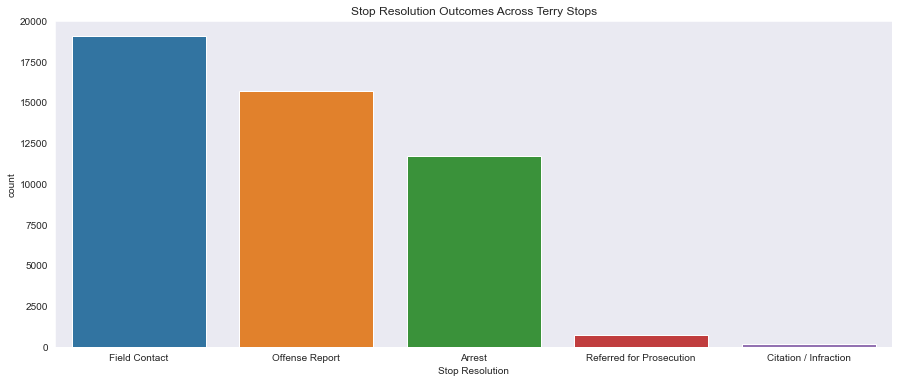

In [14]:
# visualize distinction of value counts among Stop Resolution values

f = plt.figure(figsize=(15, 6))
sns.set_style("dark")
sns.countplot(data=df_ts, x='Stop Resolution', order=df_ts['Stop Resolution'].value_counts().index, orient="v")
plt.title("Stop Resolution Outcomes Across Terry Stops");

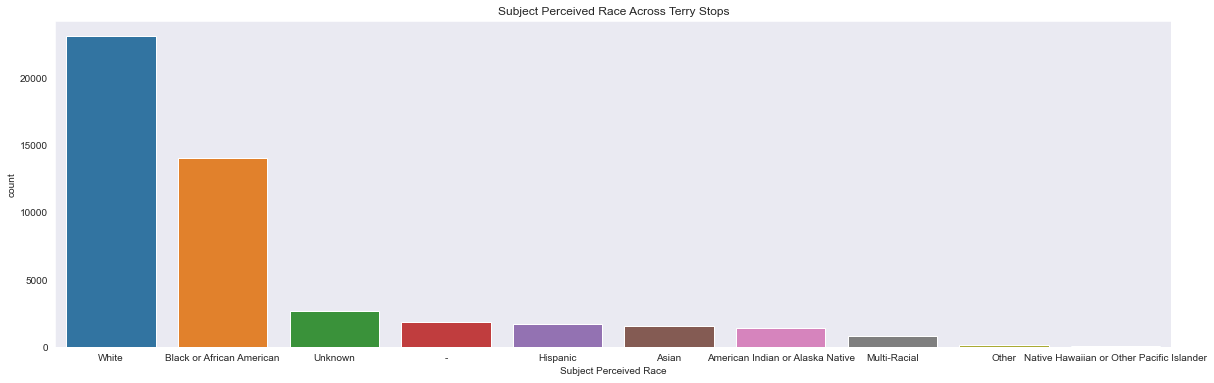

In [14]:
# visualize distinction of value counts among perceived races of subjects

f = plt.figure(figsize=(20, 6))
sns.set_style("dark")
sns.countplot(data=df_ts, x='Subject Perceived Race', order=df_ts['Subject Perceived Race'].value_counts().index, orient="v")
plt.title("Subject Perceived Race Across Terry Stops");

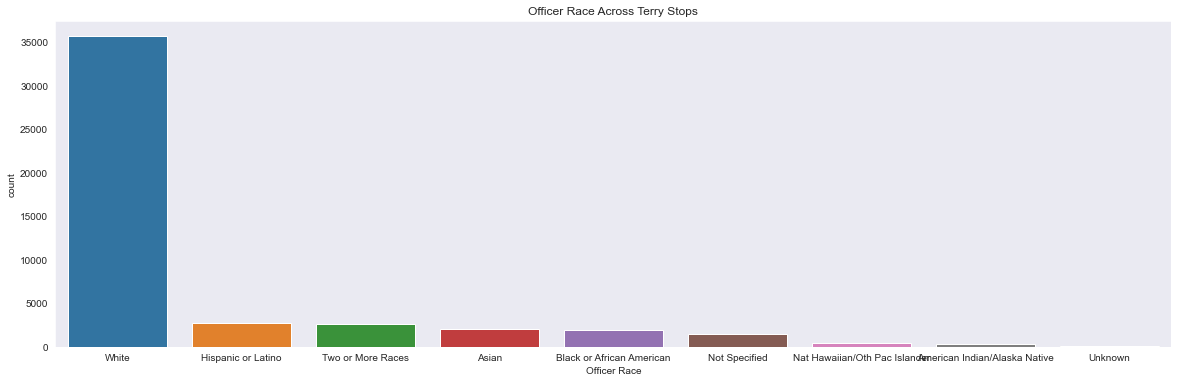

In [15]:
# visualize distinction of value counts among officer race

f = plt.figure(figsize=(20, 6))
sns.set_style("dark")
sns.countplot(data=df_ts, x='Officer Race', order=df_ts['Officer Race'].value_counts().index, orient="v")
plt.title("Officer Race Across Terry Stops");

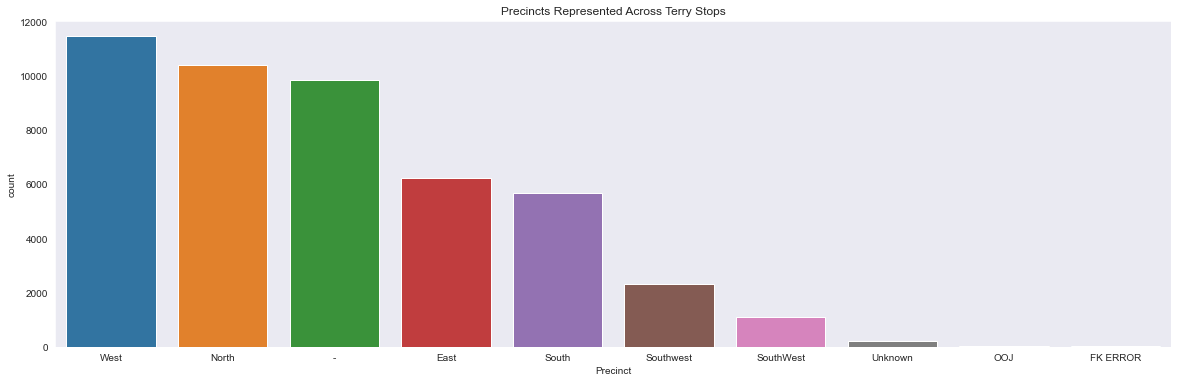

In [16]:
# visualize distinction of value counts among represented precincts

f = plt.figure(figsize=(20, 6))
sns.set_style("dark")
sns.countplot(data=df_ts, x='Precinct', order=df_ts['Precinct'].value_counts().index, orient="v")
plt.title("Precincts Represented Across Terry Stops");

After investigating our column, we can see that `Stop Resolution` is the best way to determine if a Terry Stop resulted in an outcome that could be considered significant or life-altering.

Of the disparate value counts, we concluded that `Field Contact` and `Citation / Infraction` represent 40.6% of results and could be considered less significant to a person's livelihood. In comparison, `Offense Report`, `Arrest`, and `Referred for Prosecution` represented 59.4% of data and each represent a life-altering outcome for the individual stopped.

Since our objective is to help predict whether an arrest was made after a Terry Stop, representing a binary classification problem, we'll want to ensure our target variable, `Stop Resolution`, is prepared for the algorithms we'll use to make this estimation.

In [15]:
df_ts["Stop Resolution"].value_counts().to_dict()

{'Field Contact': 19048,
 'Offense Report': 15657,
 'Arrest': 11685,
 'Referred for Prosecution': 728,
 'Citation / Infraction': 179}

In [16]:
# map to column

df_ts['Stop Resolution'] = df_ts['Stop Resolution'].map({'Field Contact': 0,
                                                   'Offense Report': 1,
                                                   'Arrest': 1,
                                                   'Referred for Prosecution': 1,
                                                   'Citation / Infraction': 0})


Let's also ensure other columns we deem significant are clearly prepared and represented for modeling.

In [17]:
df_ts['Weapon Type'].value_counts()

None                                    32565
-                                       11935
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         636
Handgun                                   291
Firearm Other                             100
Blunt Object/Striking Implement            86
Club, Blackjack, Brass Knuckles            49
Firearm                                    38
Mace/Pepper Spray                          28
Other Firearm                              23
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
Fire/Incendiary Device                      7
None/Not Applicable                         7
Rifle                                       7
Shotgun                                     3
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Blackjack                                   1
Brass Knuckles                    

In [18]:
df_ts["Weapon Type"].value_counts().to_dict()

{'None': 32565,
 '-': 11935,
 'Lethal Cutting Instrument': 1482,
 'Knife/Cutting/Stabbing Instrument': 636,
 'Handgun': 291,
 'Firearm Other': 100,
 'Blunt Object/Striking Implement': 86,
 'Club, Blackjack, Brass Knuckles': 49,
 'Firearm': 38,
 'Mace/Pepper Spray': 28,
 'Other Firearm': 23,
 'Firearm (unk type)': 15,
 'Taser/Stun Gun': 10,
 'Club': 9,
 'Fire/Incendiary Device': 7,
 'None/Not Applicable': 7,
 'Rifle': 7,
 'Shotgun': 3,
 'Personal Weapons (hands, feet, etc.)': 2,
 'Automatic Handgun': 2,
 'Blackjack': 1,
 'Brass Knuckles': 1}

In [19]:
df_ts['Weapon Type'] = df_ts['Weapon Type'].map({'None': 'NA',
                                           '-': 'NA',
                                           'Lethal Cutting Instrument': 'Non-Firearm',
                                           'Knife/Cutting/Stabbing Instrument': 'Non-Firearm',
                                           'Handgun': 'Firearm',
                                           'Firearm Other': 'Firearm',
                                           'Blunt Object/Striking Implement': 'Non-Firearm',
                                           'Club, Blackjack, Brass Knuckles': 'Non-Firearm',
                                           'Firearm': 'Firearm',
                                           'Mace/Pepper Spray': 'Non-Firearm',
                                           'Other Firearm': 'Firearm',
                                           'Firearm (unk type)': 'Firearm',
                                           'Taser/Stun Gun': 'Non-Firearm',
                                           'Club': 'Non-Firearm',
                                           'Fire/Incendiary Device': 'Non-Firearm',
                                           'None/Not Applicable': 'NA',
                                           'Rifle': 'Firearm',
                                           'Shotgun': 'Firearm',
                                           'Personal Weapons (hands, feet, etc.)': 'Non-Firearm',
                                           'Automatic Handgun': 'Firearm',
                                           'Blackjack': 'Non-Firearm',
                                           'Brass Knuckles': 'Non-Firearm'})

In [20]:
df_ts.drop(columns=['Subject Age Group','Subject ID','GO / SC Num','Terry Stop ID','Officer ID','Officer Race',
                'Reported Date','Reported Time','Initial Call Type','Final Call Type','Arrest Flag','Call Type','Sector','Beat'], axis=1, inplace=True)

In [21]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47297 entries, 0 to 47296
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Stop Resolution           47297 non-null  int64 
 1   Weapon Type               47297 non-null  object
 2   Officer YOB               47297 non-null  int64 
 3   Officer Gender            47297 non-null  object
 4   Subject Perceived Race    47297 non-null  object
 5   Subject Perceived Gender  47297 non-null  object
 6   Frisk Flag                47297 non-null  object
 7   Precinct                  47297 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.9+ MB


## Train Test Split

In [22]:
X = df_ts.loc[:, ['Weapon Type','Frisk Flag','Precinct','Officer Gender','Subject Perceived Gender',
                  'Subject Perceived Race']]
y = df_ts.loc[:, 'Stop Resolution'] #see Smote

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [23]:
# use ohe on training data
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

# create dataframe with training and testing data
ohe_df1 = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df2 = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test.columns))
ohe_df = pd.concat([ohe_df1,ohe_df2])

## Create Logistic Regression Model

In [24]:
lr_one = LogisticRegression()
lr_one = lr_one.fit(X_train_ohe, y_train)

# preview model params
print(lr_one)

# predict
y_pred = lr_one.predict(X_test_ohe)

# evaluate model with a classification report
display(classification_report(y_test, y_pred))

LogisticRegression()


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


'              precision    recall  f1-score   support\n\n           0       0.90      0.54      0.67      5809\n           1       0.75      0.96      0.84      8381\n\n    accuracy                           0.79     14190\n   macro avg       0.83      0.75      0.76     14190\nweighted avg       0.81      0.79      0.77     14190\n'

In [33]:
# evaluate model with confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[3110 2699]
 [ 336 8045]]


## Iterate on Logistic Regression Model

In [26]:
lr_two = LogisticRegression(solver='liblinear',penalty='l1',C=.5)
lr_two = lr_two.fit(X_train_ohe, y_train)

# preview model params
print(lr_two)

# predict
y_pred = lr_two.predict(X_test_ohe)

# evaluate model with a classification report
classification_report(y_test, y_pred)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')


'              precision    recall  f1-score   support\n\n           0       0.90      0.54      0.67      5809\n           1       0.75      0.96      0.84      8381\n\n    accuracy                           0.79     14190\n   macro avg       0.83      0.75      0.76     14190\nweighted avg       0.81      0.79      0.77     14190\n'

In [27]:
# evaluate model with confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[3110 2699]
 [ 336 8045]]


## Create Decision Tree Model

In [34]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train_ohe, y_train)
dt.score(X_train_ohe, y_train)

0.7911619899114991

In [35]:
# evaluate model with confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[3110 2699]
 [ 336 8045]]


## Iterate on Decision Tree Model

In [36]:
dt_two = DecisionTreeClassifier(max_depth=3)
dt_two.fit(X_train_ohe, y_train)
dt_two.score(X_train_ohe, y_train)

0.7884133264868457

In [37]:
# evaluate model with confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[3110 2699]
 [ 336 8045]]


Alternating depth is just the start for the amount of tweaking we can do in order to improve the accuracy of our models.